In [1]:

import random
import pickle
import glob
import numpy as np, pandas as pd, matplotlib.pyplot as plt 
from pathlib import Path
import io
from PIL import Image

In [2]:
DIRECTORY = "dataset\spectograms"

CATEGORIES = ["Blåmeis", "Dompap", "Fossekall", "Granmeis", "Gråspurv", "Grønnfink", "Grønnsisik", "Kjøttmeis", "Kråke", "Nøtteskrike", "Pilfink"]

In [3]:
# Her henter vi hvert treningsbilde inn i en array og setter dem inn i data[] sammen med svaret på hilket dyr det er. 
# Her opplevde vi noe problemer med at enkelte bilder bli lest som null når det ble hentet, så vi må sjekke at vi ikke får null verdi på bilden.
# De som får null verdi hopper vi over.


import cv2 as cv
import os

data = []

for category in CATEGORIES:
    folder = os.path.join(DIRECTORY, category)
    label = CATEGORIES.index(category)
    for img in os.listdir(folder):
        img_path = os.path.join(folder, img)
        img_arr = cv.imread(img_path)
        if img_arr is None:
            print('Error: could not read image at', img_path)
        else:
            data.append([img_arr, label])

Error: could not read image at dataset\spectograms\Blåmeis\199410.png
Error: could not read image at dataset\spectograms\Blåmeis\199417.png
Error: could not read image at dataset\spectograms\Blåmeis\204387.png
Error: could not read image at dataset\spectograms\Blåmeis\204388.png
Error: could not read image at dataset\spectograms\Blåmeis\204391.png
Error: could not read image at dataset\spectograms\Blåmeis\208387.png
Error: could not read image at dataset\spectograms\Blåmeis\211821.png
Error: could not read image at dataset\spectograms\Blåmeis\212009.png
Error: could not read image at dataset\spectograms\Blåmeis\212013.png
Error: could not read image at dataset\spectograms\Blåmeis\212015.png
Error: could not read image at dataset\spectograms\Blåmeis\212018.png
Error: could not read image at dataset\spectograms\Blåmeis\212109.png
Error: could not read image at dataset\spectograms\Blåmeis\212882.png
Error: could not read image at dataset\spectograms\Blåmeis\214872.png
Error: could not rea

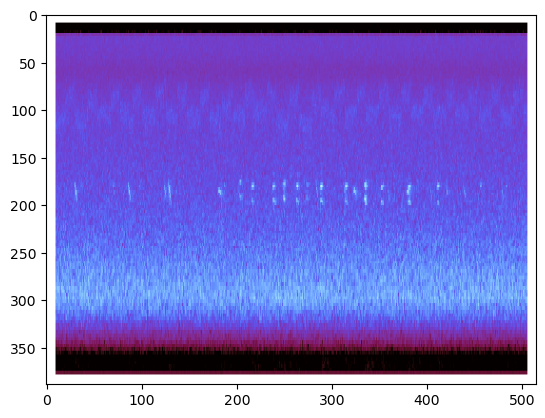

In [4]:
plt.imshow(data[1][0])
# Eksempel på ett av bildene i data[].

In [5]:
random.shuffle(data)
# Her tar vi å stokker om slik at vi ikke får samme type dyr gruppet sammen når vi skal trene modellen.

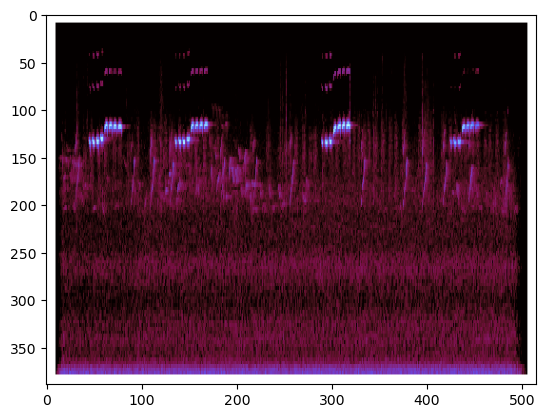

In [6]:
plt.imshow(data[1][0])
# Her henter vi et bilde fra data[] som er på akkurat samme plass som det bildet vi hentet tidligere, som vi kan se er bildet annerleds enn istad.
# Det er et bevis på at shuffle metoden fungerte!

In [7]:
X = []
Y = []

for features, labels in data:
    X.append(features)
    Y.append(labels)
# Splitter treningsdataen for å forbedrede den til modell-trening.

In [8]:
X = np.array(X)
Y = np.array(Y)
# Setter X og Y verdiene inn i en array.

In [9]:
X = X/255
# Deler treningsdataen på 255 fordi hver piksel kan ha en verdi fra 0 til 255. Ved å dele på 255 vil vi stadardisere dataen, 
# slik at den blir mellom 0 til 1.

In [10]:
X.shape
# 1725 er antall bilder vi har i X, (300, 300) er begge størrelsen på bildene, og 3 står for hvert fargelag (r = rød, g = grønn, b = blå)

(334, 389, 515, 3)

In [17]:
Y.shape

(334,)

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [12]:
model = Sequential()
# Oppretter modellen sequential.

model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add(MaxPooling2D((2,2)))
# Her legger vi til et layer av det opprinnelige bildet. Her lærer vi 32 antall filtre, og har en kernel_size på (3,3) som er høyden
# og bredden på konvolusjon området.
# det samme skjer nedover bare med forskjellig antall filtre.
# MaxPooling2D konverterer så Conv2D inn til et todimentsjonalt filter.


model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3,3), activation = 'relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256, (3,3), activation = 'relu'))
model.add(MaxPooling2D((2,2)))


# Flatten() samler så alle filterene og gjør det klar for å kunne brukes.
# Dense() er de to siste grafene for output.
# Disse blir de to siste stegene etter hidden-layer.
model.add(Flatten())

model.add(Dense(256, input_shape = X.shape[1:], activation='relu'))

model.add(Dense(6, activation='softmax'))

In [24]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

In [25]:
# kopilerer modellen med 'adam' 
model.compile(optimizer= 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Her trener vi opp modellen med 5 intervaller og 10% av den fulle test dataen blir reservert til testing av den ferdigtrente modellen.
model.fit(X, Y, epochs=5, validation_split=0.1)

Epoch 1/5
10/10 [==============================] - 24s 2s/step - loss: 2.3060 - accuracy: 0.2900 - val_loss: 1.4510 - val_accuracy: 0.2059
Epoch 2/5
10/10 [==============================] - 17s 2s/step - loss: 1.3080 - accuracy: 0.4333 - val_loss: 1.2642 - val_accuracy: 0.4412
Epoch 3/5
10/10 [==============================] - 17s 2s/step - loss: 1.1907 - accuracy: 0.4733 - val_loss: 1.1777 - val_accuracy: 0.5294
Epoch 4/5
10/10 [==============================] - 17s 2s/step - loss: 1.0706 - accuracy: 0.5633 - val_loss: 1.0774 - val_accuracy: 0.5882
Epoch 5/5
10/10 [==============================] - 52s 6s/step - loss: 0.9670 - accuracy: 0.6533 - val_loss: 0.9791 - val_accuracy: 0.6765


In [26]:
filename = "keras_model.pkl"
pickle.dump(model, open(filename, "wb"))

INFO:tensorflow:Assets written to: ram://f1b76d14-786a-49db-87e2-6b2e9410364e/assets


INFO:tensorflow:Assets written to: ram://f1b76d14-786a-49db-87e2-6b2e9410364e/assets


In [29]:
# Import required libraries
from PIL import Image
import numpy as np

# Load the image and resize it to match the input shape of your model
img = Image.open('test/white-troated dipper.png')

img_width = 224
img_height = 224
num_channels = 3

img = img.resize((img_width, img_height))

# Convert the image to a NumPy array and normalize the pixel values
img_arr = np.array(img) / 255.0

# Reshape the NumPy array to match the input shape of your model
img_arr = img_arr.reshape(1, img_width, img_height, num_channels)

# Get the predicted class probabilities for the image
pred_probs = model.predict(img_arr)

# Get the class index with the highest probability
pred_class = np.argmax(pred_probs, axis=1)[0]

# If you used LabelEncoder to encode your string labels, you can use inverse_transform() method to get the predicted class label
pred_label = label_encoder.inverse_transform([pred_class])[0]

# Print the predicted class label
print(f"Predicted class label: {pred_label}")


NameError: name 'img_width' is not defined